# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine **which demographic groups respond best to which offer type.** This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. **You'll want to try to assess what a certain demographic group will buy when not receiving any offers.**

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [1]:
import pandas as pd
import numpy as np
import math
import json
% matplotlib inline
from pandas.io.json import json_normalize
import sqlite3
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, fbeta_score, make_scorer
import seaborn as sn
import pickle

In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Step 1: Data Exploration

### exploration of portfolio data

In [3]:
def df_exploration(df):
    """
    prints stats of a DataFrame
    
    input:
    df - DataFrame that should be analyzed
    """ 
    print('example records:')
    print(df.head())
    print('\ndataframe size: {}'.format(df.shape))
    print('\ndescriptive statistics:')
    print(df.describe())
    print('\nNan Values:')
    print(df.isna().sum())

df_exploration(portfolio)

example records:
                       channels  difficulty  duration  \
0       [email, mobile, social]          10         7   
1  [web, email, mobile, social]          10         5   
2          [web, email, mobile]           0         4   
3          [web, email, mobile]           5         7   
4                  [web, email]          20        10   

                                 id     offer_type  reward  
0  ae264e3637204a6fb9bb56bc8210ddfd           bogo      10  
1  4d5c57ea9a6940dd891ad53e9dbe8da0           bogo      10  
2  3f207df678b143eea3cee63160fa8bed  informational       0  
3  9b98b8c7a33c4b65b9aebfe6a799e6d9           bogo       5  
4  0b1e1539f2cc45b7b9fa7c272da2e1d7       discount       5  

dataframe size: (10, 6)

descriptive statistics:
       difficulty   duration     reward
count   10.000000  10.000000  10.000000
mean     7.700000   6.500000   4.200000
std      5.831905   2.321398   3.583915
min      0.000000   3.000000   0.000000
25%      5.000000   5.00

### exploration of profile data

example records:
   age  became_member_on gender                                id    income
0  118          20170212   None  68be06ca386d4c31939f3a4f0e3dd783       NaN
1   55          20170715      F  0610b486422d4921ae7d2bf64640c50b  112000.0
2  118          20180712   None  38fe809add3b4fcf9315a9694bb96ff5       NaN
3   75          20170509      F  78afa995795e4d85b5d9ceeca43f5fef  100000.0
4  118          20170804   None  a03223e636434f42ac4c3df47e8bac43       NaN

dataframe size: (17000, 5)

descriptive statistics:
                age  became_member_on         income
count  17000.000000      1.700000e+04   14825.000000
mean      62.531412      2.016703e+07   65404.991568
std       26.738580      1.167750e+04   21598.299410
min       18.000000      2.013073e+07   30000.000000
25%       45.000000      2.016053e+07   49000.000000
50%       58.000000      2.017080e+07   64000.000000
75%       73.000000      2.017123e+07   80000.000000
max      118.000000      2.018073e+07  120000.0000

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2ab925b908>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f2ab9237358>]], dtype=object)

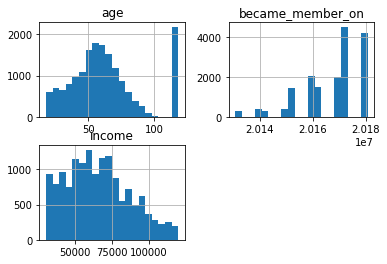

In [4]:
df_exploration(profile)

print('\ncount gender')
print(profile.gender.value_counts())
profile.hist(bins=20)

There are a lot of records with an age of 118 which look suspicious. So let's take a closer look.

In [5]:
cust_118 = profile[profile['age']==118]
print('example records:')
print(cust_118.head())
print('\ndataframe size: {}'.format(cust_118.shape))
print('\nNan Values:')
print(cust_118.isna().sum())

example records:
   age  became_member_on gender                                id  income
0  118          20170212   None  68be06ca386d4c31939f3a4f0e3dd783     NaN
2  118          20180712   None  38fe809add3b4fcf9315a9694bb96ff5     NaN
4  118          20170804   None  a03223e636434f42ac4c3df47e8bac43     NaN
6  118          20170925   None  8ec6ce2a7e7949b1bf142def7d0e0586     NaN
7  118          20171002   None  68617ca6246f4fbc85e91a2a49552598     NaN

dataframe size: (2175, 5)

Nan Values:
age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64


These records completly contain nan values in the gender and income columns. As they don't deliver much information I will drop these 2175 records from the dataset during data cleaning.

### exploration of transcript data

example records:
            event                            person  time  \
0  offer received  78afa995795e4d85b5d9ceeca43f5fef     0   
1  offer received  a03223e636434f42ac4c3df47e8bac43     0   
2  offer received  e2127556f4f64592b11af22de27a7932     0   
3  offer received  8ec6ce2a7e7949b1bf142def7d0e0586     0   
4  offer received  68617ca6246f4fbc85e91a2a49552598     0   

                                              value  
0  {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}  
1  {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}  
2  {'offer id': '2906b810c7d4411798c6938adc9daaa5'}  
3  {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}  
4  {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}  

dataframe size: (306534, 4)

descriptive statistics:
                time
count  306534.000000
mean      366.382940
std       200.326314
min         0.000000
25%       186.000000
50%       408.000000
75%       528.000000
max       714.000000

Nan Values:
event     0
person    0
time      0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2ab9054dd8>]], dtype=object)

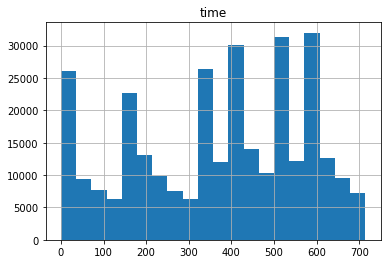

In [6]:
df_exploration(transcript)

print('\ncount events:')
event_count = pd.DataFrame(transcript.event.value_counts())
event_count['percent'] = event_count['event']/sum(event_count['event'])*100
print(event_count)
transcript.hist(bins=20)

## Step 2: Data Cleaning

age                 0
became_member_on    0
gender              0
person              0
income              0
dtype: int64


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2ab9030fd0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f2ab8f9dac8>]], dtype=object)

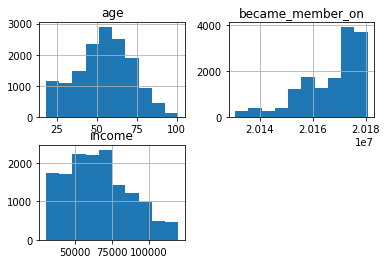

In [7]:
# remove customer records with age 118
cust_clean = profile.drop(profile[profile['age']==118].index)
cust_clean.columns = ['age', 'became_member_on', 'gender', 'person', 'income']
print(cust_clean.isna().sum())
cust_clean.hist()

In [8]:
# extract values from dictionary in value column from transcipt dataframe
value_extracted = json_normalize(transcript['value']) 

# column value contains 'offer id' and 'offer_id' which were extracted in separate columns  
combine_offer = lambda s1, s2: s1 if pd.isnull(s2) else s2

# combine offer id columns with above combination rule
result = value_extracted['offer_id'].combine(value_extracted['offer id'], combine_offer)

# drop original columns, add combined column and merge dataframe 
value_extracted.drop(['offer id','offer_id'], inplace=True, axis=1)
value_extracted['offer_id'] = result
transcript = transcript.merge(value_extracted, left_index=True, right_index=True)

# drop original value column with dictionary data
transcript.drop('value',axis=1,inplace=True)

# merge customer and transaction data
cust_trans = cust_clean.merge(transcript, how='inner', on='person')
print('We have lost {} ({}%) transaction records due to cleaning profile data.'.format(transcript.shape[0] - cust_trans.shape[0], round((transcript.shape[0] - cust_trans.shape[0])/transcript.shape[0]*100,2)))
cust_trans.head()

We have lost 33772 (11.02%) transaction records due to cleaning profile data.


,age,became_member_on,gender,person,income,event,time,amount,reward,offer_id
0,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,transaction,18,21.51,NaN,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,transaction,144,32.28,NaN,NaN
2,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,offer received,408,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
3,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,offer received,504,NaN,NaN,3f207df678b143eea3cee63160fa8bed
4,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,transaction,528,23.22,NaN,NaN


In [9]:
portfolio.columns = ['channels', 'difficulty', 'duration', 'offer_id', 'offer_type', 'reward']
df = cust_trans.merge(portfolio, on='offer_id', how='left')

### distribution and outliers

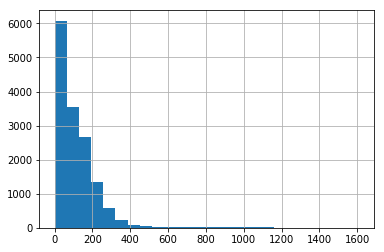

In [10]:
df.groupby('person').sum()['amount'].hist(bins=25)

--> The amount spend per customer has a right skewness with a long left tail. There are a lot of people who have not spend money during the 30 day test period, which sounds legitimate to me, while other have spend several hundreds of dollars. Let's have a closer look at these outliers.

In [11]:
amount_per_customer = pd.DataFrame(df.groupby('person').sum()['amount'].sort_values( ascending=False))
print(amount_per_customer.head(10))
amount_per_customer.describe()

                                   amount
person                                   
3c8d541112a74af99e88abbd0692f00e  1608.69
f1d65ae63f174b8f80fa063adcaa63b7  1365.66
ae6f43089b674728a50b8727252d3305  1327.74
626df8678e2a4953b9098246418c9cfa  1321.42
73afdeca19e349b98f09e928644610f8  1319.97
52959f19113e4241a8cb3bef486c6412  1292.86
ad1f0a409ae642bc9a43f31f56c130fc  1258.19
d240308de0ee4cf8bb6072816268582b  1251.99
946fc0d3ecc4492aa4cc06cf6b1492c3  1232.40
6406abad8e2c4b8584e4f68003de148d  1211.76


,amount
count,14825.000000
mean,117.028155
std,129.965016
min,0.000000
25%,31.450000
50%,87.040000
75%,160.900000
max,1608.690000


upper limit: 355.08
number of customers: 14825
number of outliers: 472
percentage of outliers: 3.18%


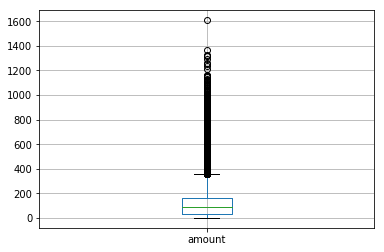

In [12]:
Q1 = 31.45
Q3 = 160.9
IQR = Q3 - Q1 #calculate Inter Quartile Range
upper_outlier_limit = Q3 + 1.5*IQR #calculate upper limit
print('upper limit: {}'.format(round(upper_outlier_limit,2)))
print('number of customers: {}'.format(len(amount_per_customer)))
print('number of outliers: {}'.format(len(amount_per_customer[amount_per_customer['amount']>upper_outlier_limit])))
print('percentage of outliers: {}%'.format(round(len(amount_per_customer[amount_per_customer['amount']>upper_outlier_limit])/len(amount_per_customer)*100,2)))

amount_per_customer.boxplot('amount')

### Assign transactions to offers

Assigning revenues from transactions to offers needs some complex joins, which are easier to do in SQL. So we will load the data in a SQLite database to join and aggregate the data. Revenue which could not be assigend to an successfull completed offer, will be aggregated under a default offer id 999.

In [13]:
df_person_trans = df[ (df['event'] == 'transaction')][['person','time','event','amount']]
df_person_offer = df[(df['event'] == 'offer received')][['person','time','offer_id','event','duration','offer_type']]
df_person_comp = df[(df['event'] == 'offer completed')][['person','time','offer_id','event']]
df_person_offer_viewed = df[(df['event'] == 'offer viewed')][['person','time','offer_id','event']]

In [14]:
#create a database in memory
conn = sqlite3.connect(':memory:')

#write the tables
df_person_trans.to_sql('transact', conn, index=False)
df_person_offer.to_sql('offer_received', conn, index=False)
df_person_comp.to_sql('comp',conn, index=False)
df_person_offer_viewed.to_sql('offer_viewed',conn, index=False)

qry ='''
        SELECT 
          t.person,
          CASE WHEN o.offer_id is not null THEN o.offer_id 
               WHEN info.offer_id is not null THEN info.offer_id
               ELSE 999 END offer,
          CASE WHEN o.offer_id is not null THEN o.time
               WHEN info.offer_id is not null THEN info.time END time,
          SUM(amount) sum_amount
        
        FROM 
          transact t
        
        LEFT JOIN 
            (SELECT 
              distinct ore.person, 
              ore.time,
              CASE WHEN ov.person is null THEN ore.time ELSE ov.time END offer_start,
              ore.offer_id,
              CASE WHEN c.time is not null THEN c.time ELSE ore.time+(ore.duration*24) END offer_end
            FROM 
              offer_received ore
            INNER JOIN 
              comp c ON c.person = ore.person 
                        AND c.offer_id = ore.offer_id 
                        AND c.time < ore.time+(ore.duration*24)
                        AND c.time > ore.time
            INNER JOIN 
              offer_viewed ov ON ov.person = ore.person 
                                 AND ov.offer_id = ore.offer_id 
                                 AND ov.time < ore.time+(ore.duration*24)
                                 AND ov.time > ore.time
                                 AND ov.time < c.time) o
        
        ON t.person = o.person 
           AND t.time BETWEEN o.offer_start AND o.offer_end
        
        LEFT JOIN
              (SELECT 
                distinct ore.person, 
                ore.time,
                CASE WHEN ov.person is null THEN ore.time ELSE ov.time END offer_start,
                ore.offer_id,
                ore.time+(ore.duration*24) offer_end
              FROM 
                offer_received ore
              INNER JOIN 
                offer_viewed ov ON ov.person = ore.person 
                                 AND ov.offer_id = ore.offer_id 
                                 AND ov.time < ore.time+(ore.duration*24)
                                 AND ov.time > ore.time
              WHERE 
                ore.offer_type IN ('informational')) info
        
        ON t.person = info.person 
           AND t.time BETWEEN info.offer_start AND info.offer_end
           
        GROUP BY 
          t.person,
          CASE WHEN o.offer_id is not null THEN o.offer_id 
               WHEN info.offer_id is not null THEN info.offer_id
               ELSE 999 END,
          CASE WHEN o.offer_id is not null THEN o.time
               WHEN info.offer_id is not null THEN info.time END
        
'''
#create an analytical table which assigns offer_ids to transactions
agg_revenue = pd.read_sql_query(qry, conn)
agg_revenue.head(10)

,person,offer,time,sum_amount
0,0009655768c64bdeb2e877511632db8f,999,NaN,96.87
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,336.0,8.57
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,168.0,22.16
3,0011e0d4e6b944f998e987f904e8c1e5,999,NaN,45.48
4,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,408.0,22.05
5,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,168.0,11.93
6,0011e0d4e6b944f998e987f904e8c1e5,9b98b8c7a33c4b65b9aebfe6a799e6d9,504.0,22.05
7,0020c2b971eb4e9188eac86d93036a77,999,NaN,161.99
8,0020c2b971eb4e9188eac86d93036a77,4d5c57ea9a6940dd891ad53e9dbe8da0,408.0,17.24
9,0020c2b971eb4e9188eac86d93036a77,fafdcd668e3743c1bb461111dcafc2a4,0.0,17.63


## Data Exploration after Cleaning

In [15]:
#check offer completion rates
offers_send = pd.DataFrame(df[df['event']=='offer received'].groupby('offer_id').count()['person'])
offers_compl = pd.DataFrame(agg_revenue.groupby('offer').count()['person'])
offers_combined = offers_send.merge(offers_compl, how='left',right_index = True, left_index = True)
offers_combined.columns = ['offers_send','offers_comleted']
offers_combined['rate'] = round((offers_combined['offers_comleted']/offers_combined['offers_send'])*100,2)
offers_combined.merge(portfolio, how='left', left_index=True, right_on=['offer_id']).sort_values('rate',ascending=False).drop('channels',axis=1)

,offers_send,offers_comleted,rate,difficulty,duration,offer_id,offer_type,reward
6,6652,2915,43.82,10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
5,6655,2580,38.77,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
7,6643,2381,35.84,0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,6576,1897,28.85,5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
0,6683,1728,25.86,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,6593,1552,23.54,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,6657,1518,22.80,0,4,3f207df678b143eea3cee63160fa8bed,informational,0
9,6631,1485,22.39,10,7,2906b810c7d4411798c6938adc9daaa5,discount,2
3,6685,1410,21.09,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,6726,1111,16.52,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [29]:
#check financial impact
print('revenue in test period:\n {}'.format(round(agg_revenue['sum_amount'].sum()),2))
print('\nrevenue assigned to offers in test period:\n {}'.format(agg_revenue[agg_revenue['offer']!=999]['sum_amount'].sum()))
print('\nrevenue by offer:')
print(agg_revenue.groupby('offer').sum()['sum_amount'].sort_values(ascending=False))
print('\n {}% of revenue could be assigned to offers.'.format(round(agg_revenue[agg_revenue['offer']!=999]['sum_amount'].sum()/agg_revenue['sum_amount'].sum()*100,2)))

revenue in test period:
 1767247.0

revenue assigned to offers in test period:
 441770.25

revenue by offer:
offer
999                                 1325476.91
fafdcd668e3743c1bb461111dcafc2a4      74126.89
2298d6c36e964ae4a3e7e9706d1fb8c2      49728.70
5a8bc65990b245e5a138643cd4eb9837      48794.16
ae264e3637204a6fb9bb56bc8210ddfd      47114.64
4d5c57ea9a6940dd891ad53e9dbe8da0      41520.18
3f207df678b143eea3cee63160fa8bed      40966.10
f19421c1d4aa40978ebb69ca19b0e20d      40822.09
0b1e1539f2cc45b7b9fa7c272da2e1d7      38149.37
2906b810c7d4411798c6938adc9daaa5      32330.28
9b98b8c7a33c4b65b9aebfe6a799e6d9      28217.84
Name: sum_amount, dtype: float64

 25.0% of revenue could be assigned to offers.


In [34]:
# merge analytical table with customer information
agg_revenue.merge(cust_clean, on='person').drop(['time','became_member_on'],axis=1).head(15)

,person,offer,sum_amount,age,gender,income
0,0009655768c64bdeb2e877511632db8f,999,96.87,33,M,72000.0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,8.57,33,M,72000.0
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,22.16,33,M,72000.0
3,0011e0d4e6b944f998e987f904e8c1e5,999,45.48,40,O,57000.0
4,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,22.05,40,O,57000.0
5,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,11.93,40,O,57000.0
6,0011e0d4e6b944f998e987f904e8c1e5,9b98b8c7a33c4b65b9aebfe6a799e6d9,22.05,40,O,57000.0
7,0020c2b971eb4e9188eac86d93036a77,999,161.99,59,F,90000.0
8,0020c2b971eb4e9188eac86d93036a77,4d5c57ea9a6940dd891ad53e9dbe8da0,17.24,59,F,90000.0
9,0020c2b971eb4e9188eac86d93036a77,fafdcd668e3743c1bb461111dcafc2a4,17.63,59,F,90000.0


In [ ]:
#Select only merge all offers send

In [21]:

agg_revenue.to_sql('agg_revenue',conn, index=False)
cust_clean.to_sql('cust_clean',conn, index=False)
portfolio.drop('channels',axis=1).to_sql('portfolio',conn, index=False)

qry ='''
        SELECT 
          ore.person, 
          ore.time, 
          ore.offer_id, 
          CASE WHEN ar.sum_amount IS NOT NULL THEN ar.sum_amount ELSE 0 END revenue,
          cc.age,
          cc.income,
          cc.gender,
          SUBSTR(cc.became_member_on,1,4) member_year,
          p.difficulty,
          p.duration,
          p.reward,
          p.offer_type
        FROM 
          offer_received ore
        LEFT JOIN 
          agg_revenue ar ON ar.person = ore.person 
                         AND ar.time = ore.time
                         AND ar.offer = ore.offer_id
        LEFT JOIN 
          cust_clean cc ON cc.person = ore.person
        LEFT JOIN 
          portfolio p ON p.offer_id = ore.offer_id
        
'''

features = pd.read_sql_query(qry, conn)
features.head()

,person,time,offer_id,revenue,age,income,gender,member_year,difficulty,duration,reward,offer_type
0,0610b486422d4921ae7d2bf64640c50b,408,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.00,55,112000.0,F,2017,5,7,5,bogo
1,0610b486422d4921ae7d2bf64640c50b,504,3f207df678b143eea3cee63160fa8bed,0.00,55,112000.0,F,2017,0,4,0,informational
2,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,19.89,75,100000.0,F,2017,5,7,5,bogo
3,78afa995795e4d85b5d9ceeca43f5fef,168,5a8bc65990b245e5a138643cd4eb9837,49.39,75,100000.0,F,2017,0,3,0,informational
4,78afa995795e4d85b5d9ceeca43f5fef,408,ae264e3637204a6fb9bb56bc8210ddfd,0.00,75,100000.0,F,2017,10,7,10,bogo


In [22]:
#one hot encoding for categorical values
gender_one_hot = pd.get_dummies(features['gender'],prefix='gender')
offer_type_one_hot = pd.get_dummies(features['offer_type'],prefix='type')
year_one_hot = pd.get_dummies(features['member_year'],prefix='year')

#replace original categorical columns
features = features.merge(gender_one_hot, right_index=True, left_index=True)
features = features.merge(offer_type_one_hot, right_index=True, left_index=True)
features = features.merge(year_one_hot, right_index=True, left_index=True)

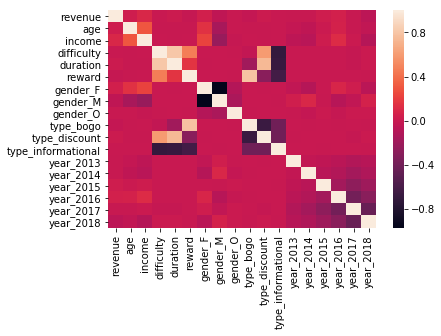

In [23]:
correlation_matrix = features.iloc[:,3:].corr()
sn.heatmap(correlation_matrix)

In [24]:
#separate features and target
features.drop(['gender','offer_type','member_year'], axis=1, inplace=True)
X = features.iloc[:,4:]
y = np.sign(features['revenue'])
print(X.head())
print(y.head())

   age    income  difficulty  duration  reward  gender_F  gender_M  gender_O  \
0   55  112000.0           5         7       5         1         0         0   
1   55  112000.0           0         4       0         1         0         0   
2   75  100000.0           5         7       5         1         0         0   
3   75  100000.0           0         3       0         1         0         0   
4   75  100000.0          10         7      10         1         0         0   

   type_bogo  type_discount  type_informational  year_2013  year_2014  \
0          1              0                   0          0          0   
1          0              0                   1          0          0   
2          1              0                   0          0          0   
3          0              0                   1          0          0   
4          1              0                   0          0          0   

   year_2015  year_2016  year_2017  year_2018  
0          0          0         

## Step 3: Create and train the model

In [25]:
#split test and training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [53]:
rfc = RandomForestClassifier()

scorer = make_scorer(fbeta_score,
                     beta=0.5)

# create the random grid
random_grid = {'n_estimators': [50, 100, 150, 200, 250, 300],
                   'max_features': ['auto', 'sqrt'],
                   'max_depth': [int(x) for x in np.arange(5, 11)],
                   'min_samples_split': [2, 5, 10],
                   'min_samples_leaf': [1, 2, 4]}
 
rf_random = RandomizedSearchCV(estimator = rfc,
                                   param_distributions = random_grid,
                                   scoring=scorer,
                                   n_iter = 100,
                                   cv = 3,
                                   verbose=2,
                                   random_state=0,
                                   n_jobs = 3)

rf_random.fit(X_train, y_train)

pickle.dump(rf_random, open('rfc.sav', 'wb'))
print('model exported')

#scores = cross_val_score(rf_random, X_train, y_train, scoring='accuracy', cv=10)
#print(scores)
#print(scores.mean())


Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] n_estimators=200, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=9 
[CV] n_estimators=200, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=9 
[CV] n_estimators=200, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=9 
[CV]  n_estimators=200, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=9, total=  17.2s
[CV] n_estimators=100, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=9 
[CV]  n_estimators=200, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=9, total=  17.2s
[CV] n_estimators=100, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=9 
[CV]  n_estimators=200, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=9, total=  17.2s
[CV] n_estimators=100, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=9 
[CV]  n_estimators=100, min_

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=100, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=5, total=   6.0s
[CV] n_estimators=150, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=9 
[CV]  n_estimators=100, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=5, total=   5.9s
[CV] n_estimators=150, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=9 
[CV]  n_estimators=100, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=5, total=   6.0s
[CV] n_estimators=150, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=9 
[CV]  n_estimators=150, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=9, total=  13.0s
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=10 
[CV]  n_estimators=150, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=9, total=  13.0s
[CV] n_estimators=200, min_samples_split=10, min_samples

[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:  2.9min


[CV]  n_estimators=200, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=10, total=  18.2s
[CV] n_estimators=200, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=6 
[CV]  n_estimators=200, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=6, total=  13.0s
[CV] n_estimators=300, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=7 
[CV]  n_estimators=200, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=6, total=  13.0s
[CV] n_estimators=300, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=7 
[CV]  n_estimators=200, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=6, total=  13.0s
[CV] n_estimators=300, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=7 
[CV]  n_estimators=300, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=7, total=  21.4s
[CV] n_estimators=250, min_samples_split=5, min_samples_lea

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=250, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=5, total=  14.1s
[CV] n_estimators=300, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=7 
[CV]  n_estimators=250, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=5, total=  14.2s
[CV] n_estimators=300, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=7 
[CV]  n_estimators=250, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=5, total=  14.4s
[CV] n_estimators=300, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=7 
[CV]  n_estimators=300, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=7, total=  21.5s
[CV] n_estimators=50, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=8 
[CV]  n_estimators=300, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=7, total=  21.7s
[CV] n_estimators=50, min_samples_split=2, min_samples_le

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=150, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=5, total=   8.4s
[CV] n_estimators=50, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=9 
[CV]  n_estimators=150, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=5, total=   8.5s
[CV] n_estimators=50, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=9 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=150, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=5, total=   8.5s
[CV] n_estimators=50, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=9 
[CV]  n_estimators=50, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=9, total=   4.4s
[CV] n_estimators=150, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=10 
[CV]  n_estimators=50, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=9, total=   4.5s
[CV] n_estimators=150, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=10 
[CV]  n_estimators=50, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=9, total=   4.5s
[CV] n_estimators=150, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=10 
[CV]  n_estimators=150, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=10, total=  14.0s
[CV] n_estimators=250, min_samples_split=2, min_samples_

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=200, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=5, total=  11.3s
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=6 
[CV]  n_estimators=200, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=5, total=  11.3s
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=6 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=200, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=5, total=  11.4s
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=6 
[CV]  n_estimators=200, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=6, total=  12.8s
[CV] n_estimators=100, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=10 
[CV]  n_estimators=200, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=6, total=  12.9s
[CV] n_estimators=100, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=10 
[CV]  n_estimators=200, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=6, total=  12.8s
[CV] n_estimators=100, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=10 
[CV]  n_estimators=100, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=10, total=   9.1s
[CV] n_estimators=300, min_samples_split=10, min_

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=100, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=6, total=   6.6s
[CV] n_estimators=200, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=8 
[CV]  n_estimators=200, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=8, total=  15.4s
[CV] n_estimators=250, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=5 
[CV]  n_estimators=200, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=8, total=  15.3s
[CV] n_estimators=250, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=5 
[CV]  n_estimators=200, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=8, total=  15.4s
[CV] n_estimators=250, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=5 


[Parallel(n_jobs=3)]: Done 156 tasks      | elapsed: 12.9min
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=250, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=5, total=  14.3s
[CV] n_estimators=50, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=5 
[CV]  n_estimators=250, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=5, total=  14.3s
[CV] n_estimators=50, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=5 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=50, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=5, total=   2.9s
[CV] n_estimators=50, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=5 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=250, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=5, total=  14.3s
[CV] n_estimators=250, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=8 
[CV]  n_estimators=50, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=5, total=   2.8s
[CV] n_estimators=250, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=8 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=50, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=5, total=   2.9s
[CV] n_estimators=250, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=8 
[CV]  n_estimators=250, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=8, total=  19.9s
[CV] n_estimators=150, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=8 
[CV]  n_estimators=250, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=8, total=  19.9s
[CV] n_estimators=150, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=8 
[CV]  n_estimators=250, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=8, total=  19.9s
[CV] n_estimators=150, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=8 
[CV]  n_estimators=150, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=8, total=  11.6s
[CV] n_estimators=100, min_samples_split=5, min_samples_leaf=

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=150, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=5, total=   8.6s
[CV] n_estimators=200, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=9 
[CV]  n_estimators=150, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=5, total=   8.6s
[CV] n_estimators=200, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=9 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=150, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=5, total=   8.8s
[CV] n_estimators=200, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=9 
[CV]  n_estimators=200, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=9, total=  17.5s
[CV] n_estimators=50, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=5 
[CV]  n_estimators=200, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=9, total=  17.5s
[CV] n_estimators=50, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=5 
[CV]  n_estimators=200, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=9, total=  17.4s
[CV] n_estimators=50, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=5 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=50, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=5, total=   3.0s
[CV] n_estimators=100, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=10 
[CV]  n_estimators=50, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=5, total=   2.9s
[CV] n_estimators=100, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=10 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=50, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=5, total=   3.0s
[CV] n_estimators=100, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=10 
[CV]  n_estimators=100, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=10, total=   9.6s
[CV] n_estimators=200, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=10 
[CV]  n_estimators=100, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=10, total=   9.6s
[CV] n_estimators=200, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=10 
[CV]  n_estimators=100, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=10, total=   9.6s
[CV] n_estimators=200, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=10 
[CV]  n_estimators=200, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=10, total=  18.9s
[CV] n_estimators=100, min_samples_split=2, min_sample

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=100, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=5, total=   6.1s
[CV] n_estimators=100, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=5 
[CV]  n_estimators=100, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=5, total=   6.0s
[CV] n_estimators=100, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=5 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=100, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=5, total=   6.1s
[CV] n_estimators=100, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=5 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=100, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=5, total=   5.9s
[CV] n_estimators=250, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=5 
[CV]  n_estimators=100, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=5, total=   5.9s
[CV] n_estimators=250, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=5 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=100, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=5, total=   5.9s
[CV] n_estimators=250, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=5 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=250, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=5, total=  14.4s
[CV] n_estimators=50, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=7 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=250, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=5, total=  14.4s
[CV] n_estimators=50, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=7 
[CV]  n_estimators=250, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=5, total=  14.5s
[CV] n_estimators=50, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=7 
[CV]  n_estimators=50, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=7, total=   3.6s
[CV] n_estimators=250, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=9 
[CV]  n_estimators=50, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=7, total=   3.7s
[CV] n_estimators=250, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=9 
[CV]  n_estimators=50, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=7, total=   3.7s
[CV] n_estimators=250, min_samples_split=10, min_samples_le

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=300, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=5, total=  17.3s
[CV] n_estimators=100, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=6 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=300, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=5, total=  17.2s
[CV] n_estimators=100, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=6 
[CV]  n_estimators=300, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=5, total=  17.3s
[CV] n_estimators=100, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=6 
[CV]  n_estimators=100, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=6, total=   6.5s
[CV] n_estimators=300, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=8 
[CV]  n_estimators=100, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=6, total=   6.5s
[CV] n_estimators=300, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=8 
[CV]  n_estimators=100, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=6, total=   6.3s
[CV] n_estimators=300, min_samples_split=5, min_samples_lea

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=250, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=5, total=  14.2s
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=9 
[CV]  n_estimators=250, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=5, total=  14.3s
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=9 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=250, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=5, total=  14.3s
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=9 
[CV]  n_estimators=200, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=9, total=  17.3s
[CV] n_estimators=200, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=10 
[CV]  n_estimators=200, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=9, total=  17.3s
[CV] n_estimators=200, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=10 
[CV]  n_estimators=200, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=9, total=  17.1s
[CV] n_estimators=200, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=10 
[CV]  n_estimators=200, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=10, total=  18.8s
[CV] n_estimators=100, min_samples_split=10, min_samp

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=100, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=5, total=   5.7s
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=7 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=100, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=5, total=   5.7s
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=7 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=100, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=5, total=   6.0s
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=7 
[CV]  n_estimators=200, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=7, total=  14.4s
[CV] n_estimators=150, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=9 
[CV]  n_estimators=200, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=7, total=  14.3s
[CV] n_estimators=150, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=9 
[CV]  n_estimators=200, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=7, total=  14.4s
[CV] n_estimators=150, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=9 
[CV]  n_estimators=150, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=9, total=  13.4s
[CV] n_estimators=150, min_samples_split=5, min_samples_

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=150, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=5, total=   8.5s
[CV] n_estimators=250, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=6 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=150, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=5, total=   8.4s
[CV] n_estimators=250, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=6 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=150, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=5, total=   8.4s
[CV] n_estimators=250, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=6 
[CV]  n_estimators=250, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=6, total=  16.0s
[CV] n_estimators=200, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=7 
[CV]  n_estimators=250, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=6, total=  16.2s
[CV] n_estimators=200, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=7 
[CV]  n_estimators=250, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=6, total=  16.3s
[CV] n_estimators=200, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=7 
[CV]  n_estimators=200, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=7, total=  14.4s
[CV] n_estimators=250, min_samples_split=10, min_samples_

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=50, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=6, total=   3.5s
[CV] n_estimators=50, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=6 
[CV]  n_estimators=250, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=6, total=  16.7s
[CV] n_estimators=300, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=6 
[CV]  n_estimators=50, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=6, total=   3.3s
[CV] n_estimators=300, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=6 
[CV]  n_estimators=50, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=6, total=   3.2s
[CV] n_estimators=300, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=6 
[CV]  n_estimators=300, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=6, total=  19.2s
[CV] n_estimators=100, min_samples_split=2, min_samples_leaf=2, 

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=100, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=5, total=   5.6s
[CV] n_estimators=100, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=5 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=100, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=5, total=   5.8s
[CV] n_estimators=100, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=5 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=100, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=5, total=   5.9s
[CV] n_estimators=100, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=5 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=100, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=5, total=   5.9s
[CV] n_estimators=50, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=8 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=100, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=5, total=   6.0s
[CV] n_estimators=50, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=8 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=100, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=5, total=   5.9s
[CV] n_estimators=50, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=8 
[CV]  n_estimators=50, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=8, total=   4.1s
[CV]  n_estimators=50, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=8, total=   3.7s
[CV]  n_estimators=50, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=8, total=   2.3s


[Parallel(n_jobs=3)]: Done 300 out of 300 | elapsed: 22.7min finished


model exported


In [54]:
#loaded_model = pickle.load(open('final_model.sav', 'rb'))
rfc = rf_random.best_estimator_

scores = cross_val_score(rfc, X_train, y_train, scoring='accuracy', cv=10)
print(scores)
print(scores.mean())

[ 0.72574178  0.72534082  0.72253408  0.72754611  0.72273456  0.71832398
  0.72007219  0.72588731  0.7248847   0.72503008]
0.723809561034


In [ ]:
gbc = GradientBoostingClassifier()

scorer = make_scorer(fbeta_score,
                     beta=0.5)

# create the random grid
random_grid = {'n_estimators': [10, 30, 50, 100, 150, 200, 250, 300],
                   'learning_rate': [0.05, 0.1],
                   'max_depth': [int(x) for x in np.arange(3, 11)],
                   'min_samples_split': [2, 5, 10],
                   'min_samples_leaf': [1, 2, 4]}

gradboost_random = RandomizedSearchCV(estimator = gbc,
                                   param_distributions = random_grid,
                                   scoring=scorer,
                                   n_iter = 100,
                                   cv = 3,
                                   verbose=2,
                                   random_state=0,
                                   n_jobs = 3)

gradboost_random.fit(X_train, y_train)

pickle.dump(gradboost_random, open('gradboost.sav', 'wb'))
print('model exported')

#scores = cross_val_score(rfc, X_train, y_train, scoring='accuracy', cv=10)
#print(scores)
#print(scores.mean())


Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] n_estimators=50, min_samples_split=5, min_samples_leaf=1, max_depth=8, learning_rate=0.1 
[CV] n_estimators=50, min_samples_split=5, min_samples_leaf=1, max_depth=8, learning_rate=0.1 
[CV] n_estimators=50, min_samples_split=5, min_samples_leaf=1, max_depth=8, learning_rate=0.1 
[CV]  n_estimators=50, min_samples_split=5, min_samples_leaf=1, max_depth=8, learning_rate=0.1, total=  25.9s
[CV] n_estimators=100, min_samples_split=2, min_samples_leaf=1, max_depth=8, learning_rate=0.05 
[CV]  n_estimators=50, min_samples_split=5, min_samples_leaf=1, max_depth=8, learning_rate=0.1, total=  26.1s
[CV] n_estimators=100, min_samples_split=2, min_samples_leaf=1, max_depth=8, learning_rate=0.05 
[CV]  n_estimators=50, min_samples_split=5, min_samples_leaf=1, max_depth=8, learning_rate=0.1, total=  26.2s
[CV] n_estimators=100, min_samples_split=2, min_samples_leaf=1, max_depth=8, learning_rate=0.05 
[CV]  n_estimators=100, min_sam

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=10, min_samples_split=5, min_samples_leaf=1, max_depth=6, learning_rate=0.05, total=   2.7s
[CV] n_estimators=10, min_samples_split=5, min_samples_leaf=1, max_depth=6, learning_rate=0.05 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=10, min_samples_split=5, min_samples_leaf=1, max_depth=6, learning_rate=0.05, total=   2.6s
[CV] n_estimators=100, min_samples_split=5, min_samples_leaf=4, max_depth=9, learning_rate=0.05 
[CV]  n_estimators=200, min_samples_split=5, min_samples_leaf=1, max_depth=5, learning_rate=0.1, total=  36.4s
[CV] n_estimators=100, min_samples_split=5, min_samples_leaf=4, max_depth=9, learning_rate=0.05 
[CV]  n_estimators=200, min_samples_split=5, min_samples_leaf=1, max_depth=5, learning_rate=0.1, total=  38.2s
[CV] n_estimators=100, min_samples_split=5, min_samples_leaf=4, max_depth=9, learning_rate=0.05 
[CV]  n_estimators=100, min_samples_split=5, min_samples_leaf=4, max_depth=9, learning_rate=0.05, total=  56.8s
[CV] n_estimators=50, min_samples_split=5, min_samples_leaf=4, max_depth=5, learning_rate=0.05 
[CV]  n_estimators=100, min_samples_split=5, min_samples_leaf=4, max_depth=9, learning_rate=0.05, total= 1.0min
[CV] n_estimators=50, min_samples_split=5, min_samples_l

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=10, min_samples_split=5, min_samples_leaf=1, max_depth=3, learning_rate=0.05, total=   1.0s
[CV] n_estimators=10, min_samples_split=5, min_samples_leaf=1, max_depth=3, learning_rate=0.05 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=10, min_samples_split=5, min_samples_leaf=1, max_depth=3, learning_rate=0.05, total=   1.1s
[CV] n_estimators=10, min_samples_split=5, min_samples_leaf=1, max_depth=3, learning_rate=0.05 
[CV]  n_estimators=50, min_samples_split=5, min_samples_leaf=4, max_depth=5, learning_rate=0.05, total=   9.1s
[CV] n_estimators=250, min_samples_split=2, min_samples_leaf=1, max_depth=9, learning_rate=0.1 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=10, min_samples_split=5, min_samples_leaf=1, max_depth=3, learning_rate=0.05, total=   1.2s
[CV] n_estimators=250, min_samples_split=2, min_samples_leaf=1, max_depth=9, learning_rate=0.1 
[CV]  n_estimators=100, min_samples_split=5, min_samples_leaf=4, max_depth=9, learning_rate=0.05, total= 1.1min
[CV] n_estimators=250, min_samples_split=2, min_samples_leaf=1, max_depth=9, learning_rate=0.1 
[CV]  n_estimators=250, min_samples_split=2, min_samples_leaf=1, max_depth=9, learning_rate=0.1, total= 2.7min
[CV] n_estimators=250, min_samples_split=5, min_samples_leaf=1, max_depth=3, learning_rate=0.05 
[CV]  n_estimators=250, min_samples_split=2, min_samples_leaf=1, max_depth=9, learning_rate=0.1, total= 3.0min
[CV] n_estimators=250, min_samples_split=5, min_samples_leaf=1, max_depth=3, learning_rate=0.05 


[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed: 14.0min


[CV]  n_estimators=250, min_samples_split=2, min_samples_leaf=1, max_depth=9, learning_rate=0.1, total= 3.0min
[CV] n_estimators=250, min_samples_split=5, min_samples_leaf=1, max_depth=3, learning_rate=0.05 
[CV]  n_estimators=250, min_samples_split=5, min_samples_leaf=1, max_depth=3, learning_rate=0.05, total=  21.9s
[CV] n_estimators=300, min_samples_split=10, min_samples_leaf=2, max_depth=7, learning_rate=0.1 
[CV]  n_estimators=250, min_samples_split=5, min_samples_leaf=1, max_depth=3, learning_rate=0.05, total=  21.7s
[CV] n_estimators=300, min_samples_split=10, min_samples_leaf=2, max_depth=7, learning_rate=0.1 
[CV]  n_estimators=250, min_samples_split=5, min_samples_leaf=1, max_depth=3, learning_rate=0.05, total=  23.3s
[CV] n_estimators=300, min_samples_split=10, min_samples_leaf=2, max_depth=7, learning_rate=0.1 
[CV]  n_estimators=300, min_samples_split=10, min_samples_leaf=2, max_depth=7, learning_rate=0.1, total= 1.6min
[CV] n_estimators=250, min_samples_split=2, min_sampl

In [33]:
boost = gradboost_random.best_estimator_
scores = cross_val_score(boost, X_train, y_train, scoring='accuracy', cv=10)
print(scores)
print(scores.mean())

[ 0.70747423  0.69866838  0.70354458  0.70161117  0.70698174  0.70590763
  0.70182599  0.70504834  0.7116459   0.70799312]
0.705070107334
